In [17]:
#The Statsmodels tool accesses some deprecated libraries, which results in few warnings while running different code. 
#For the sake of clarity, we can suppress these warnings in our tutorials:
import warnings
warnings.simplefilter('ignore')

In [18]:
%matplotlib inline

import numpy as np
from scipy import stats

import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm

In [19]:
temp_df = pd.read_csv('Datasets/daily-minimum-temperatures-in-me.csv',
                      skiprows=1,
                      usecols=[1],
                      names=['Temp'], 
                      dtype=np.float,
                      sep=",")

temp_df.tail()

,Temp
3644,14.0
3645,13.6
3646,13.5
3647,15.7
3648,13.0


In [20]:
temp_df.describe()

,Temp
count,3649.000000
mean,11.175144
std,4.069341
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


<AxesSubplot:>

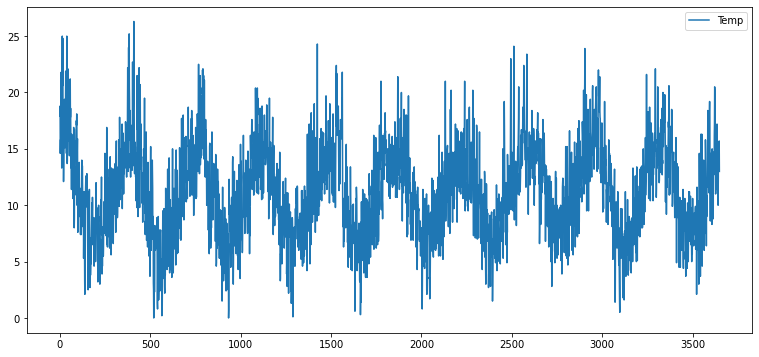

In [21]:
temp_df.plot(figsize=(13,6))

We see that the above graph seems to have a set of repeated patterns, which comes back to zero. Let us try to visually see a few parameters that will confirm if our data is a stationary series.

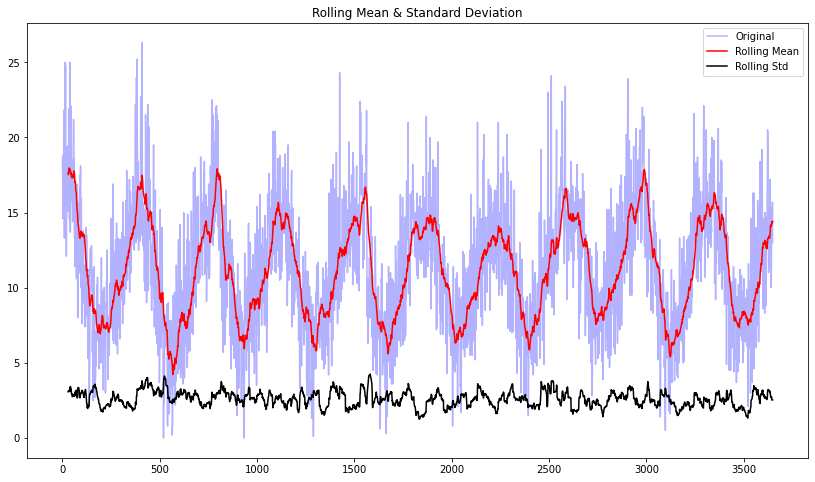

In [22]:
rolling_mean = temp_df.rolling(window=30, center=False).mean()
rolling_std = temp_df.rolling(window=30, center=False).std()

fig = plt.figure(figsize=(14, 8))

original = plt.plot(temp_df, color='blue', alpha=0.3, label='Original')
mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
std = plt.plot(rolling_std, color='black', label = 'Rolling Std')

plt.legend(loc='best') 

plt.title('Rolling Mean & Standard Deviation')
plt.show()

The mean and standard deviation seem to be constant within reasonable limits; so we can consider the series to be stationary and proceed with analysing it. 

We now need to fit a model to our time series, which we can then use to forecast/predict required parameters. Let us find try to identify what kind of process our time series is - an AutoRegressive (AR) process or Moving Average (MA) Process.

For this, we make use of the autocorrelation plots in Statsmodels.

https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html

First, we shall plot the Auto-correlation function chart, which is a plot of total correlation between different lag functions. What do we expect?

* If it is an moving average series of average lag k, the acf plot will show strong correlations up to lag k and then cut off after than
* If it is an autoregressive series, the correlation will be strong up to the lag k and then the taper off for larger lags

If the process is IID (independent and identically distributed) correlogram has all zeros except for lag 0

In [23]:
temperatures = temp_df.values

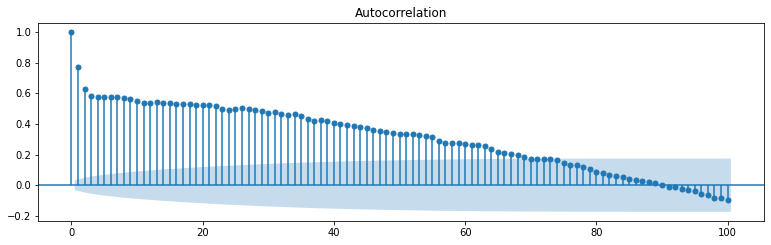

In [24]:
fig = plt.figure(figsize=(13,8))
ax1 = fig.add_subplot(211)

fig = sm.graphics.tsa.plot_acf(temperatures, lags=100, ax=ax1)

This seems like an AR series, there is no abrupt cut-off, instead there seems to be a tapering off after lag 90 or so

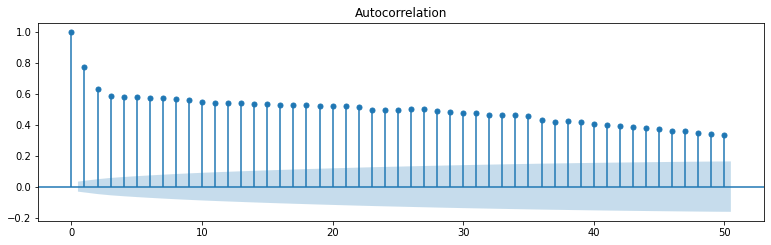

In [25]:
fig = plt.figure(figsize=(13,8))
ax1 = fig.add_subplot(211)

fig = sm.graphics.tsa.plot_acf(temperatures, lags=50, ax=ax1)

The PACF can be used to find the degree of the AR series. The partial correlation of each lag will cut off after the degree of the AR series.

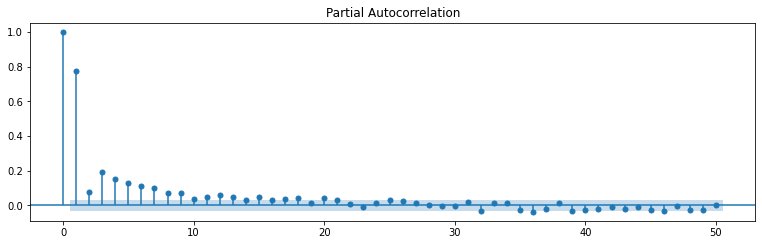

In [26]:
fig = plt.figure(figsize=(13,8))
ax2 = fig.add_subplot(212)

fig = sm.graphics.tsa.plot_pacf(temperatures, lags=50, ax=ax2)

The sticks that lie out of the blue shaded region are the values that are distinct from zero. Here, we see that the graph cuts off after the 1st lag sharply and then after around the 10th lag

We will apply the ARMA model on our data. 
We need parameters (p,q) which are the order of the model for the number of AR parameters and MA parameters, in that order. As seen above, we have a third order AR process and a 0th order MA process. Applying this on our series,

In [27]:
arma_model_2 = sm.tsa.ARMA(temperatures, (2, 0)).fit(disp=False)
arma_model_3 = sm.tsa.ARMA(temperatures, (3, 0)).fit(disp=False)
arma_model_5 = sm.tsa.ARMA(temperatures, (5, 0)).fit(disp=False)
arma_model_7 = sm.tsa.ARMA(temperatures, (7, 0)).fit(disp=False)
arma_model_10 = sm.tsa.ARMA(temperatures, (10, 0)).fit(disp=False)

We now print out the cririon for model selection:

* Hannan–Quinn information criterion (HQC) 
* Akaike information criterion (AIC) 
* Bayesian information criterion (BIC)

The aim is to find the model with the lowest value of the selected information criterion. 

In [28]:
print("Lag 2: ", arma_model_2.aic, arma_model_2.bic, arma_model_2.hqic)
print("Lag 3: ", arma_model_3.aic, arma_model_3.bic, arma_model_3.hqic)
print("Lag 5: ", arma_model_5.aic, arma_model_5.bic, arma_model_5.hqic)
print("Lag 7: ", arma_model_7.aic, arma_model_7.bic, arma_model_7.hqic)
print("Lag 10: ", arma_model_10.aic, arma_model_10.bic, arma_model_10.hqic)

Lag 2:  17239.65117410491 17264.460007850656 17248.48640162112
Lag 3:  17106.404961774213 17137.416003956394 17117.448996169474
Lag 5:  16963.436289038775 17006.851748093828 16978.89793719214
Lag 7:  16884.28547291788 16940.10534884581 16904.16473482935
Lag 10:  16846.202383683936 16920.628884921174 16872.708066232568


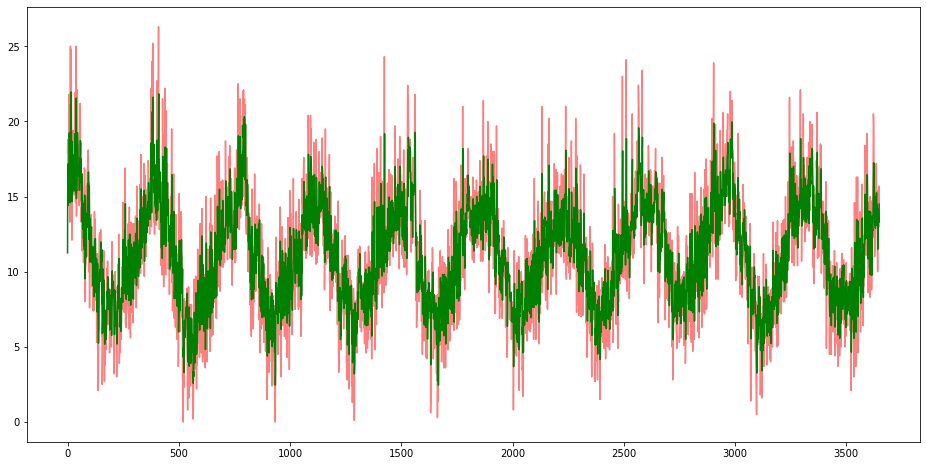

In [29]:
figure = plt.figure(figsize=(16, 8))

plt.plot(temperatures, color = 'red', alpha=0.5, label="Temperatures")
plt.plot(arma_model_10.fittedvalues, color='green', label="Fitted")

Red is the actual sunspots data curve, while green is our model fit.

Finding the Durbin_watson statistic to identify if there is autocorrelation amongst the residuals,<br>

*[The null hypothesis of the test is that there is no serial correlation*
  * *0:+ve autocorrelation;*
  * *4:-ve autocorrelation;*
  * *2:no autocorrelation]*

In [30]:
sm.stats.durbin_watson(arma_model_10.resid)

2.0013270372764533

### Working with residuals

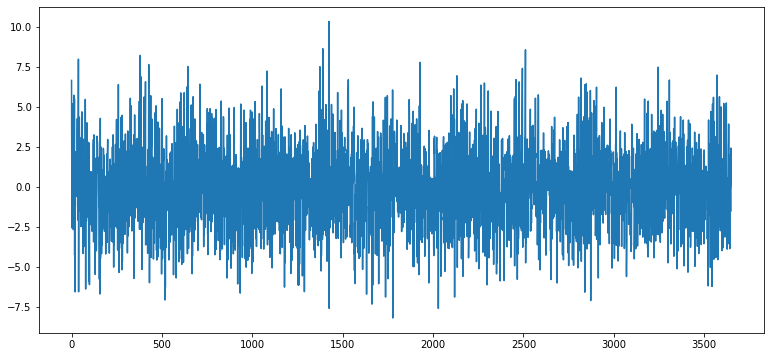

In [31]:
figure = plt.figure(figsize=(13,6))

ax = figure.add_subplot(111)
ax.plot(arma_model_10.resid);

In [35]:
arma_residual = arma_model_10.resid

Let us do a quick normality test to check if the residuals belong to a normal distribution

* The 1st value in our result is the chi-squared value and the second is the p-value.

In [36]:
stats.normaltest(arma_residual) 

NormaltestResult(statistic=11.800334183336057, pvalue=0.0027389871186041374)

### Q-Q plot

We have specified a line to be fit through the quartiles, and are telling the tool to fit the parameters 
for distribution automatically.

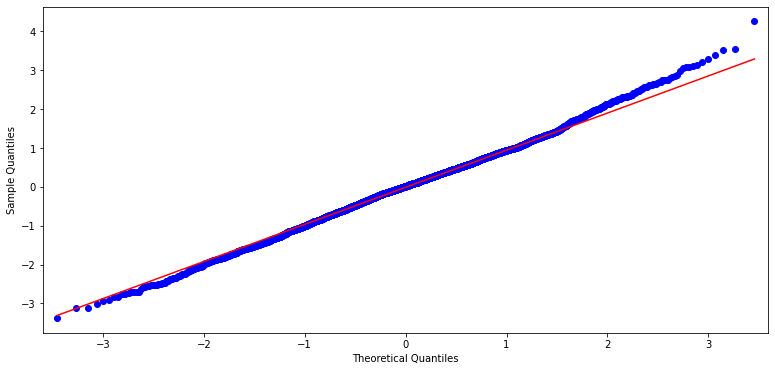

In [37]:
from statsmodels.graphics.api import qqplot

figure = plt.figure(figsize=(13, 6))
ax = figure.add_subplot(111)

figure = qqplot(arma_residual, line='q', ax=ax, fit=True)